In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Conv1D, Flatten

### Lấy dữ liệu

In [2]:
# Lấy dữ liệu chỉ số S&P 500 từ năm 2000 đến nay
ticker = "^GSPC"  # Mã của S&P 500 trên Yahoo Finance
data = yf.download(ticker, start="2000-01-01", end="2024-10-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2000-01-03,1455.219971,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


In [4]:
data.to_csv("sp500_2000.csv", header=["AdjClose","Close","High","Low","Open","Volume"])

### Xử lí dữ liệu

> Đọc dữ liệu

In [245]:
data = pd.read_csv("sp500_2000.csv", index_col=0)
data = data[['AdjClose']] 

In [246]:
data

,AdjClose
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
...,...
2024-10-24,5809.859863
2024-10-25,5808.120117
2024-10-28,5823.520020


In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6247 entries, 2000-01-03 to 2024-10-30
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AdjClose  6247 non-null   float64
dtypes: float64(1)
memory usage: 97.6+ KB


In [248]:
data.describe()

,AdjClose
count,6247.000000
mean,2086.109238
std,1206.505886
min,676.530029
25%,1199.294983
50%,1482.660034
75%,2730.164917
max,5864.669922


> Check dữ liệu thiếu

In [249]:
print(data.isnull().sum())


AdjClose    0
dtype: int64


### Trực quan dữ liệu

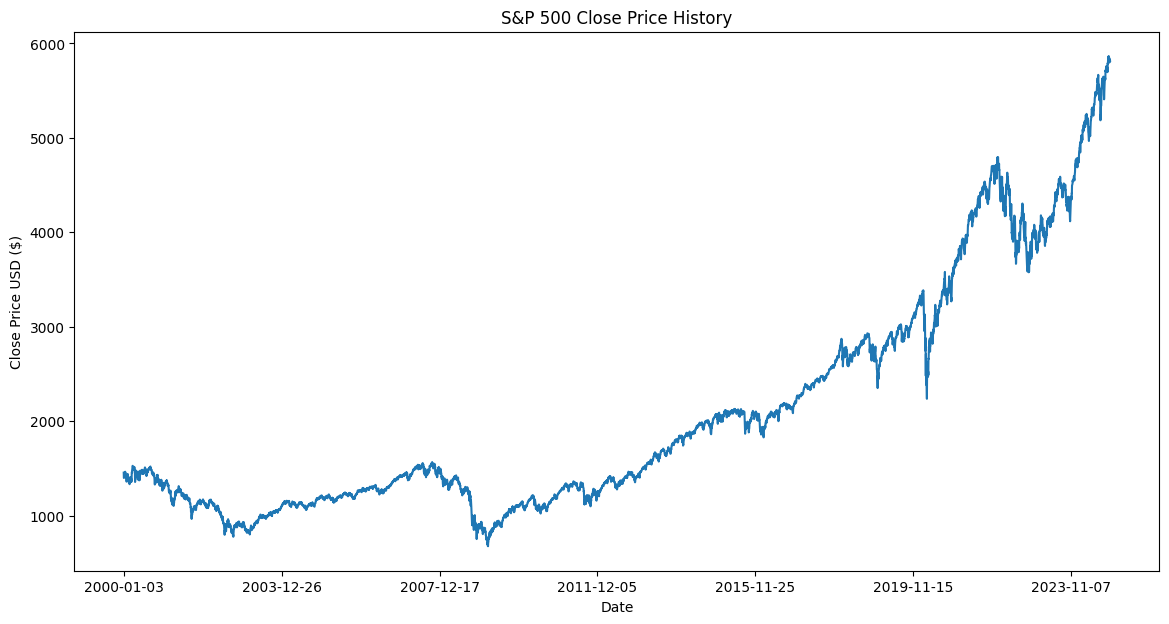

In [250]:
# Vẽ biểu đồ giá đóng cửa của S&P 500 từ năm 2000 đến nay (trục x là thời gian, hãy hiển thị số ngày theo khoảng là 1000, 2000, 3000, ... chứ không hiện ngày cụ thể)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['AdjClose'])
plt.xticks(np.arange(0, len(data), 1000), data.index[::1000])
plt.title('S&P 500 Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()


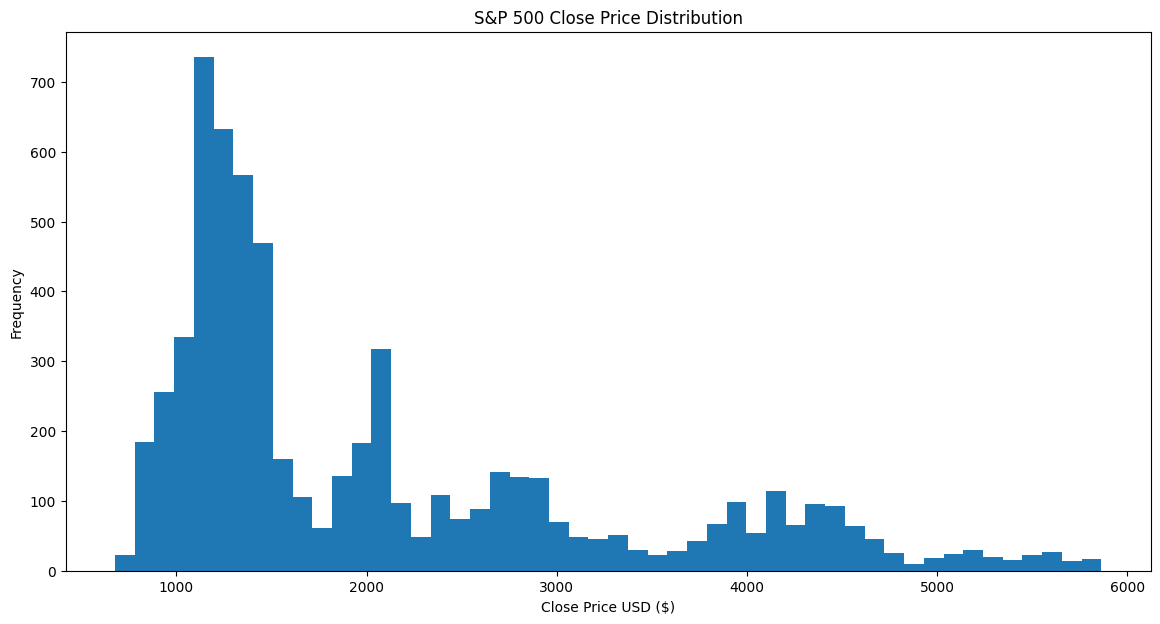

In [251]:
#plot histogram
plt.figure(figsize=(14, 7))
plt.hist(data['AdjClose'], bins=50)
plt.title('S&P 500 Close Price Distribution')
plt.xlabel('Close Price USD ($)')
plt.ylabel('Frequency')
plt.show()

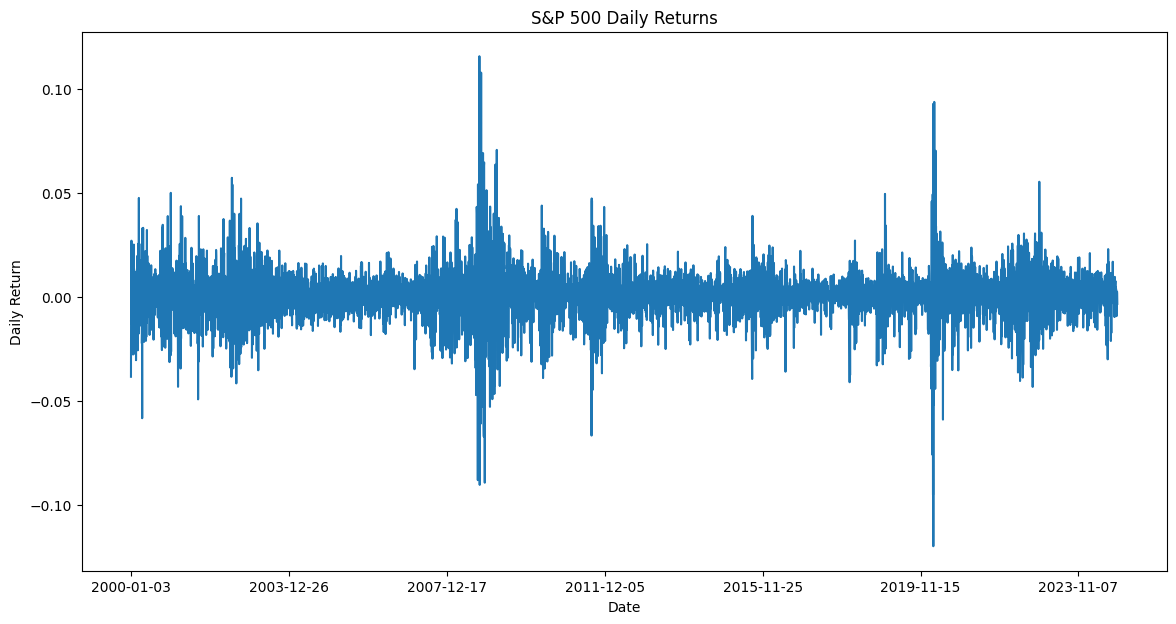

In [252]:
#return plot
data['Return'] = data['AdjClose'].pct_change()
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Return'])
plt.xticks(np.arange(0, len(data), 1000), data.index[::1000])
plt.title('S&P 500 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

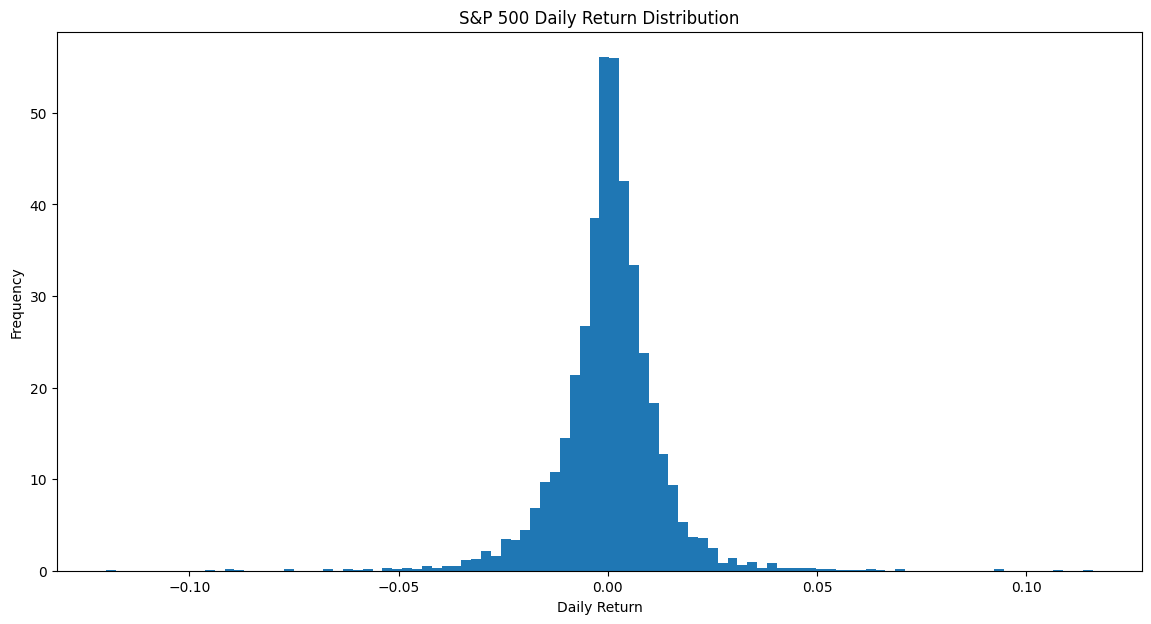

In [253]:
#histogram of return
plt.figure(figsize=(14, 7))
plt.hist(data['Return'], bins=100, density=True)
plt.title('S&P 500 Daily Return Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


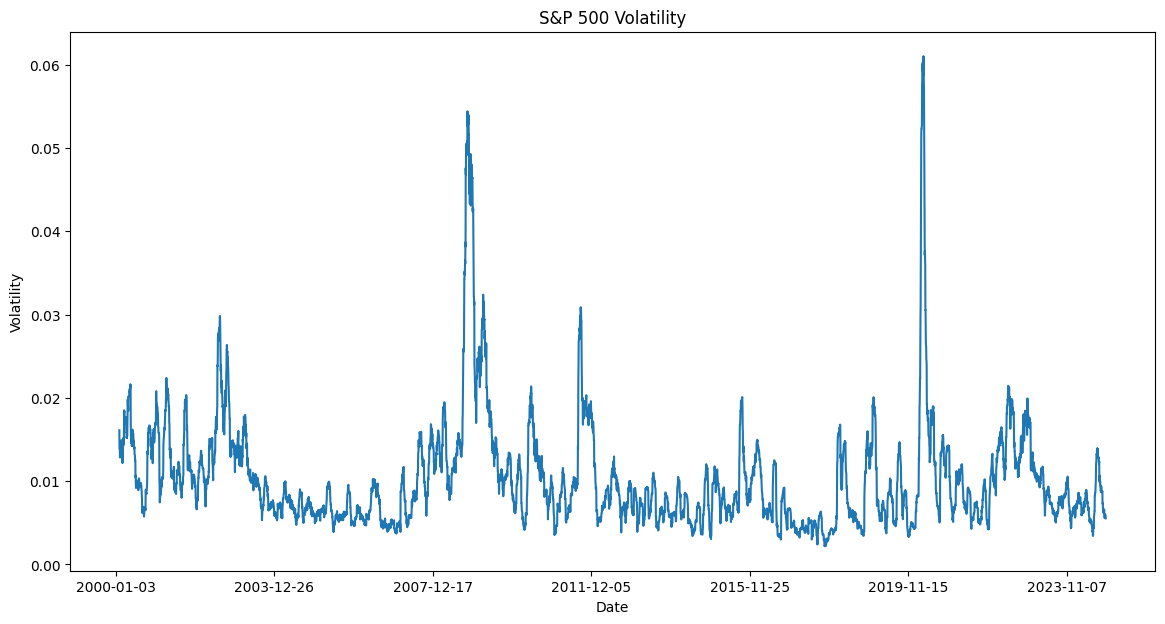

In [254]:
#Volatility Plot
data['Volatility'] = data['Return'].rolling(window=21).std()
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Volatility'])
plt.xticks(np.arange(0, len(data), 1000), data.index[::1000])
plt.title('S&P 500 Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()
data = data.drop(columns=['Return'])
data = data.drop(columns=['Volatility'])

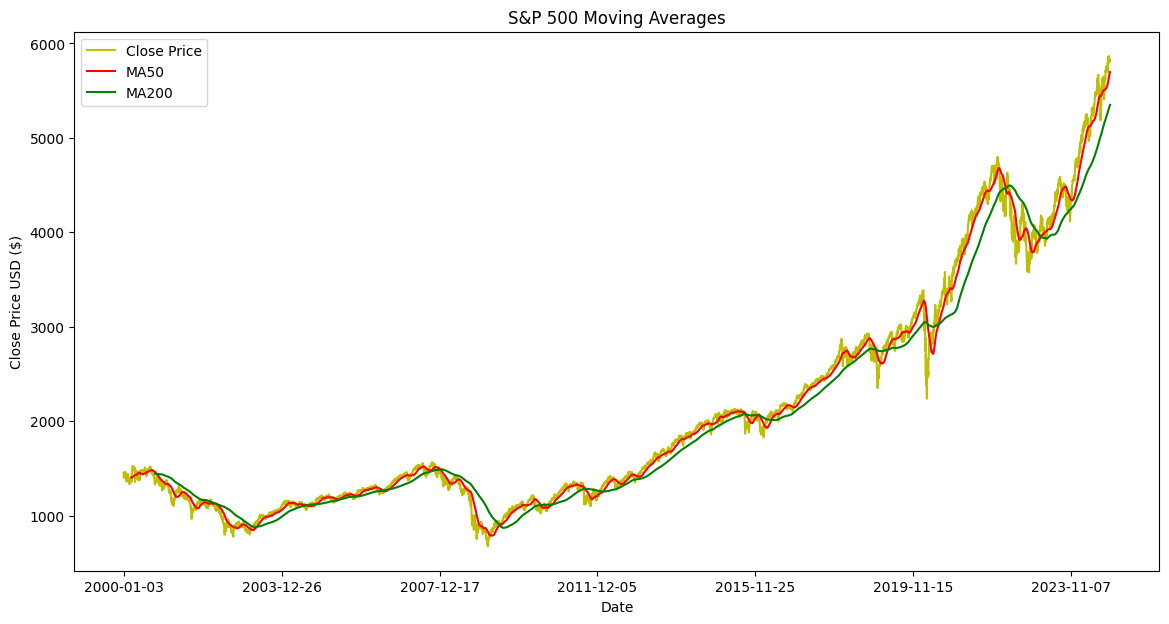

In [241]:
#plot moving average 
data['MA50'] = data['AdjClose'].rolling(window=50).mean()
data['MA200'] = data['AdjClose'].rolling(window=200).mean()
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['AdjClose'], label='Close Price', color = 'y')
plt.plot(data.index, data['MA50'], label='MA50',color = 'r')
plt.plot(data.index, data['MA200'], label='MA200', color = 'g')
plt.xticks(np.arange(0, len(data), 1000), data.index[::1000])
plt.title('S&P 500 Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()
#drop ma50 and ma200
data = data.drop(columns=['MA50'])
data = data.drop(columns=['MA200'])

> Chia dữ liệu: 70% Train/ 15% Validation/ 15% Test

In [195]:
#split train val test data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
train = data[:train_size]
val = data[train_size:train_size + val_size]
test = data[train_size + val_size:]

In [196]:
print(train.shape, val.shape, test.shape)

(4372, 1) (937, 1) (938, 1)


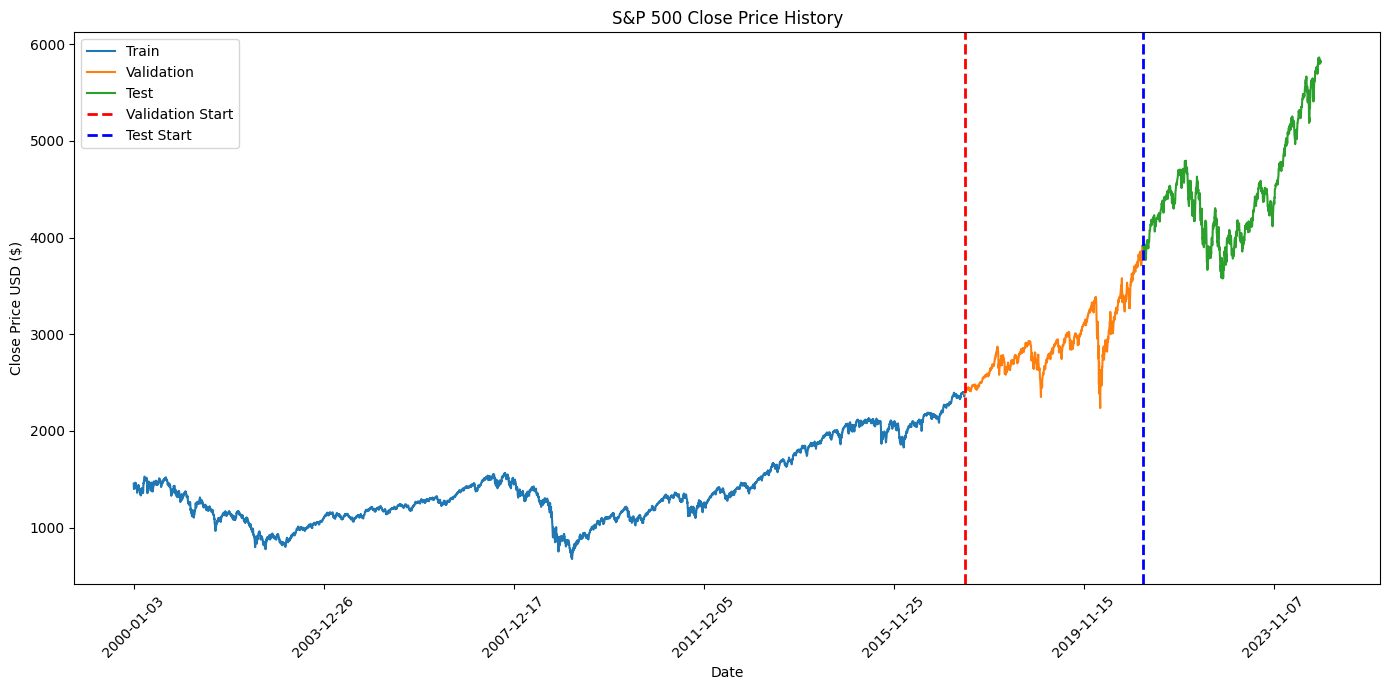

In [197]:
# Chuyển index thành Series
full_index = pd.concat([
    pd.Series(train.index),
    pd.Series(val.index),
    pd.Series(test.index)
])

# Lấy các mốc xticks mỗi 1000 ngày
xticks = full_index[::1000]

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['AdjClose'], label='Train')
plt.plot(val.index, val['AdjClose'], label='Validation')
plt.plot(test.index, test['AdjClose'], label='Test')

plt.axvline(val.index[0], color='r', linestyle='--', linewidth=2, label='Validation Start')
plt.axvline(test.index[0], color='b', linestyle='--', linewidth=2, label='Test Start')

plt.xticks(xticks, rotation=45)
plt.title('S&P 500 Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.tight_layout()
plt.show()

> Normalize Dữ liệu

$$
\begin{align}
X = \frac{X-min(X_T)}{max(X_T)-min(X_T)}
\end{align}
$$
Trong đó $X_T$ là Tập training

In [211]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [212]:
min_train = train['AdjClose'].min()
max_train = train['AdjClose'].max()

In [213]:
train_scaled = (train['AdjClose'] - min_train) / (max_train - min_train)
val_scaled = (val['AdjClose'] - min_train) / (max_train - min_train)
test_scaled = (test['AdjClose'] - min_train) / (max_train - min_train)

In [214]:
#Scale the data
train_scaled = train_scaled.values
val_scaled = val_scaled.values
test_scaled = test_scaled.values

In [215]:
train_scaled

array([0.45120781, 0.41887483, 0.42043351, ..., 0.99904383, 0.97375692,
       0.97879227])

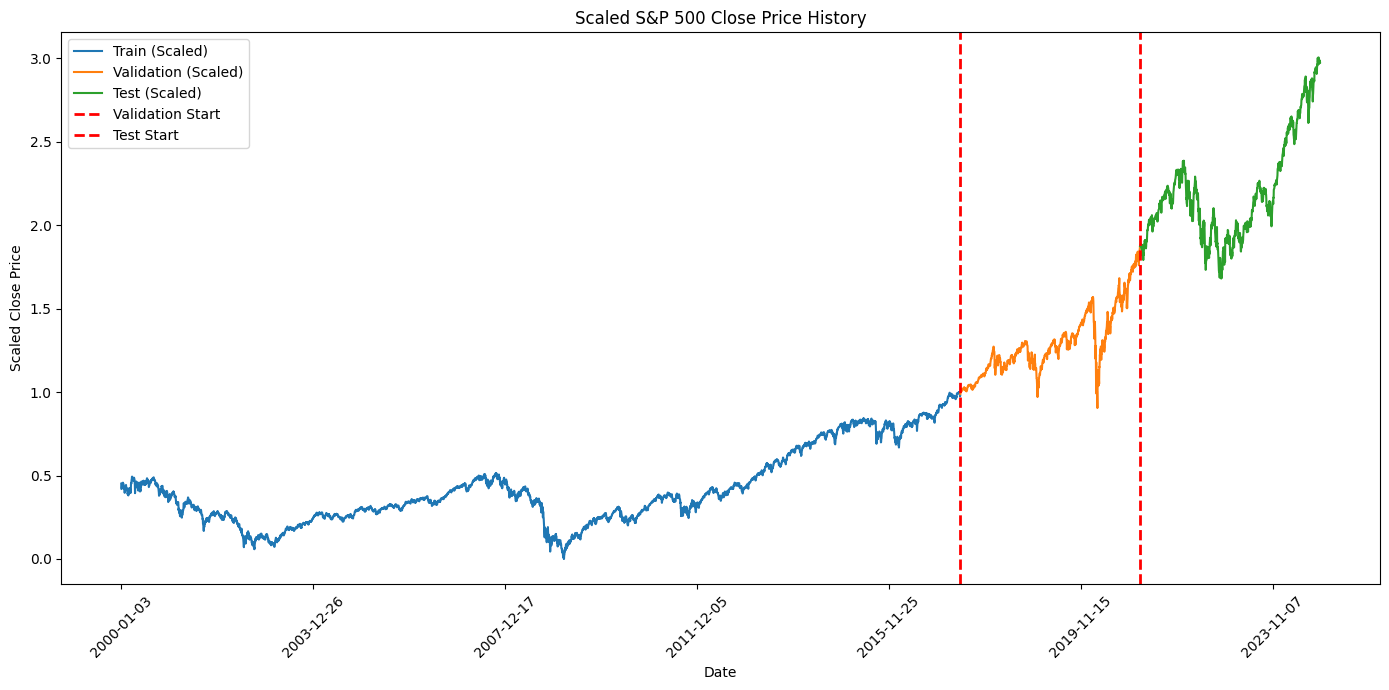

In [216]:
# Vẽ biểu đồ
plt.figure(figsize=(14, 7))

# Vẽ dữ liệu scaled với các index tương ứng
plt.plot(train.index, train_scaled, label='Train (Scaled)')
plt.plot(val.index, val_scaled, label='Validation (Scaled)')
plt.plot(test.index, test_scaled, label='Test (Scaled)')

# Thêm đường kẻ dọc tại điểm cắt
plt.axvline(val.index[0], color='r', linestyle='--', linewidth=2, label='Validation Start')
plt.axvline(test.index[0], color='r', linestyle='--', linewidth=2, label='Test Start')

# Lấy các mốc xticks từ toàn bộ dữ liệu
full_index = sorted(set(train.index).union(val.index).union(test.index))
xticks = full_index[::1000]
plt.xticks(xticks, rotation=45)

plt.title('Scaled S&P 500 Close Price History')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.tight_layout()
plt.show()


> Tạo dataset với lookback 14 ngày

In [217]:
#Create the dataset
def create_dataset(dataset, look_back=14):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back])
        y.append(dataset[i + look_back])
    return np.array(X), np.array(y)

In [218]:
#Create the dataset
look_back = 14
X_train, y_train = create_dataset(train_scaled, look_back)
X_val, y_val = create_dataset(val_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

In [219]:
#Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [220]:
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (4358, 14, 1), Validation shape: (923, 14, 1), Test shape: (924, 14, 1)


### Huấn luyện mô hình

In [221]:
#model1 fc1: Dense(14, relu)
def fc1(optimizer):
    print(optimizer)
    look_back=14
    model = Sequential()
    model.add(Dense(14, input_shape=(look_back,)))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

#model2 fc2: Dense(14, relu) -> Dense(7, relu)
def fc2(optimizer):
    print(optimizer)
    look_back=14
    model = Sequential()
    model.add(Dense(14, input_shape=(look_back,), activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

#model3 rnn1: RNN(4, relu)
def rnn1(optimizer):
    print(optimizer)
    look_back=14
    model = Sequential()
    model.add(SimpleRNN(4, input_shape=(look_back, 1), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model


#model4 rnn2: RNN(6, relu)
def rnn2(optimizer):
    print(optimizer)
    look_back=14
    model = Sequential()
    model.add(SimpleRNN(6, input_shape=(look_back, 1), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

#model5 lstm1: LSTM(6, relu)
def lstm1(optimizer):
    print(optimizer)
    look_back=14
    model = Sequential()
    model.add(LSTM(6, input_shape=(look_back, 1), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

#model6 Conv1: Conv1D(4,3,relu)
def conv1(optimizer):
    print(optimizer)
    look_back=14
    model = Sequential()
    model.add(Conv1D(4, 3, input_shape=(look_back, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model


In [ ]:
# #Train the model
# def train_model(model, X_train, y_train, X_val, y_val):
#     history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)], verbose=0)
#     return history

# #Evaluate the model
# def evaluate_model(model, X_test, y_test):
#     return model.evaluate(X_test, y_test,verbose=0)

# #Plot the training history
# def plot_history(history):
#     plt.plot(history.history['loss'], label='train')
#     plt.plot(history.history['val_loss'], label='validation')
#     plt.legend()
#     plt.show()

# def train_and_evaluate_sgd(model_x):
#     model = model_x('sgd')
#     history = train_model(model, X_train, y_train, X_val, y_val)
#     plot_history(history)
#     print(f"{model_x.__name__}: {evaluate_model(model, X_val, y_val)}")
#     print(f"{model_x.__name__}: {evaluate_model(model, X_test, y_test)}")

# def train_and_evaluate_RMSprop(model_x):
#     model = model_x('RMSprop')
#     history = train_model(model, X_train, y_train, X_val, y_val)
#     plot_history(history)
#     print(f"{model_x.__name__}: {evaluate_model(model, X_val, y_val)}")
#     print(f"{model_x.__name__}: {evaluate_model(model, X_test, y_test)}")

# def train_and_evaluate_Adam(model_x):
#     model = model_x('adam')
#     history = train_model(model, X_train, y_train, X_val, y_val)
#     plot_history(history)
#     print(f"{model_x.__name__}: {evaluate_model(model, X_val, y_val)}")
#     print(f"{model_x.__name__}: {evaluate_model(model, X_test, y_test)}")

In [255]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#Train the model
def train_model(model, X_train, y_train, X_val, y_val):
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)], verbose=0)
    plot_history(history)
    return model

#Evaluate the model
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test,verbose=0)

#Plot the training history


def train_and_evaluate_sgd(model_x):
    model = model_x('sgd')
    train_model(model, X_train, y_train, X_val, y_val)
    # plot_history(history)
    print(f"{model_x.__name__}: {evaluate_model(model, X_val, y_val)}")
    print(f"{model_x.__name__}: {evaluate_model(model, X_test, y_test)}")
    return model

def train_and_evaluate_RMSprop(model_x):
    model = model_x('RMSprop')
    train_model(model, X_train, y_train, X_val, y_val)
    print(f"{model_x.__name__}: {evaluate_model(model, X_val, y_val)}")
    print(f"{model_x.__name__}: {evaluate_model(model, X_test, y_test)}")
    return model

def train_and_evaluate_Adam(model_x):
    model = model_x('adam')
    train_model(model, X_train, y_train, X_val, y_val)
    print(f"{model_x.__name__}: {evaluate_model(model, X_val, y_val)}")
    print(f"{model_x.__name__}: {evaluate_model(model, X_test, y_test)}")
    return model

>SGD Opitmizer

sgd


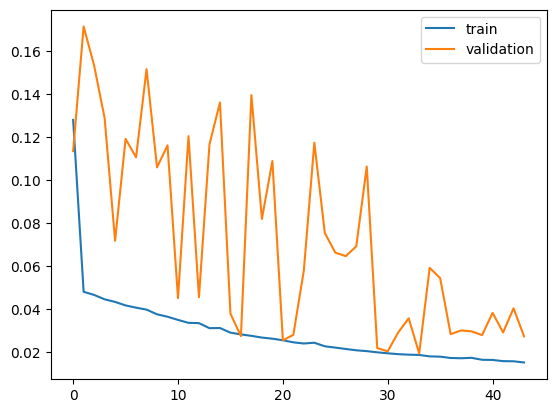

fc1: 0.02726825512945652
fc1: 0.0416683591902256


In [103]:
fc1_sgd = train_and_evaluate_sgd(fc1)

sgd


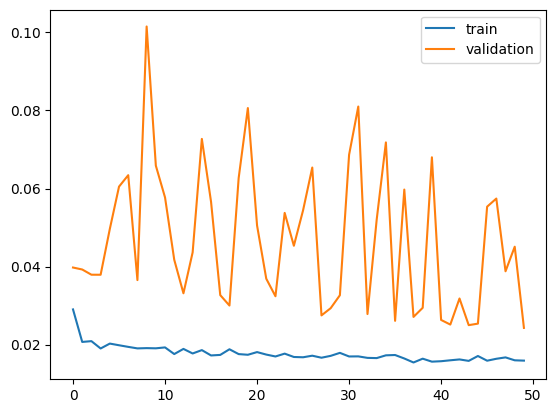

fc2: 0.024299584329128265
fc2: 0.03784633055329323


In [109]:
fc2_sgd= train_and_evaluate_sgd(fc2)

sgd


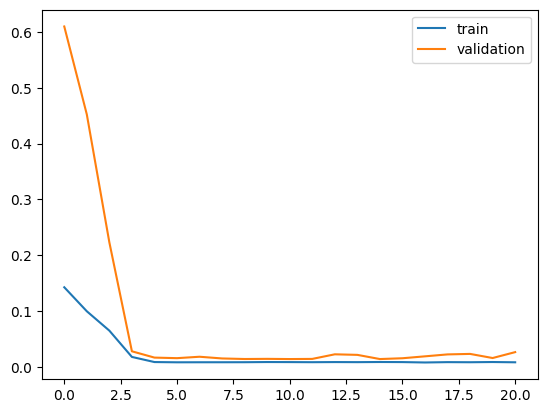

rnn1: 0.026287831366062164
rnn1: 0.03624548763036728


In [112]:
rnn1_sgd =train_and_evaluate_sgd(rnn1)

sgd


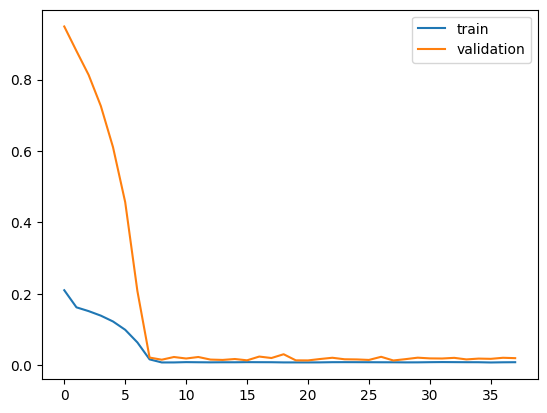

rnn2: 0.020185185596346855
rnn2: 0.026739979162812233


In [119]:
rnn2_sgd=train_and_evaluate_sgd(rnn2)

sgd


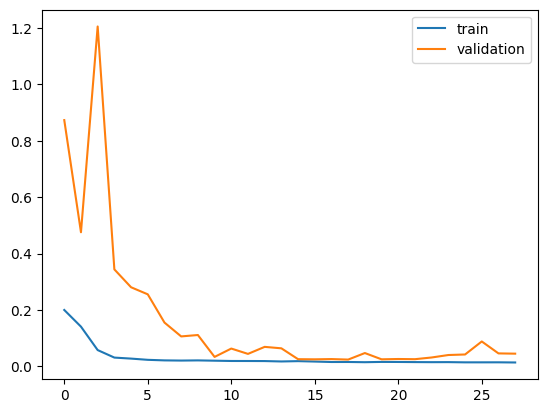

lstm1: 0.04448939487338066
lstm1: 0.1873910278081894


In [120]:
lstm1_sgd=train_and_evaluate_sgd(lstm1)

sgd


d:\Code\DL\venv\tfenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


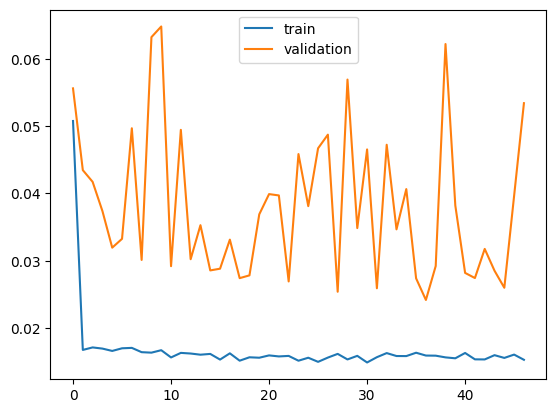

conv1: 0.05341735854744911
conv1: 0.08185124397277832


In [121]:
conv1_sgd=train_and_evaluate_sgd(conv1)

> RMSprop Optimizer

RMSprop


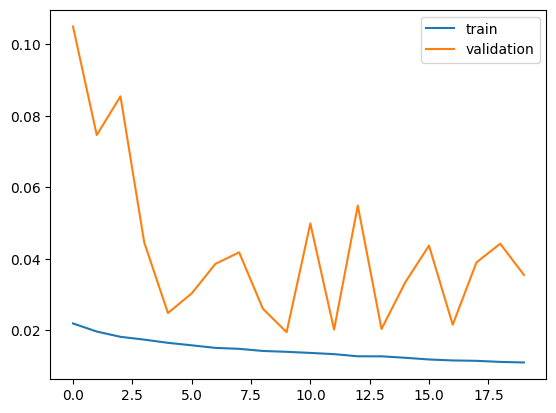

fc1: 0.03549855202436447
fc1: 0.05340207368135452


In [122]:
fc1_rms=train_and_evaluate_RMSprop(fc1)

RMSprop


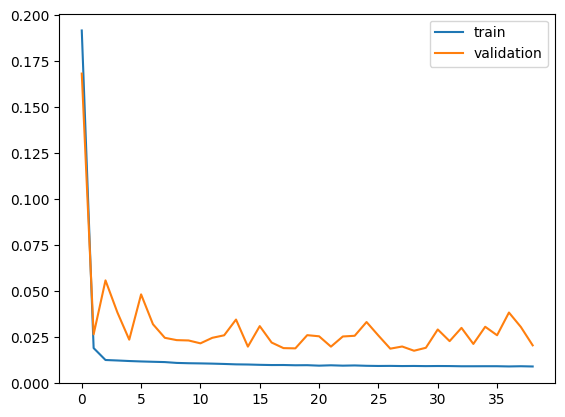

fc2: 0.020519407466053963
fc2: 0.03206031024456024


In [56]:
fc2_rms=train_and_evaluate_RMSprop(fc2)

RMSprop


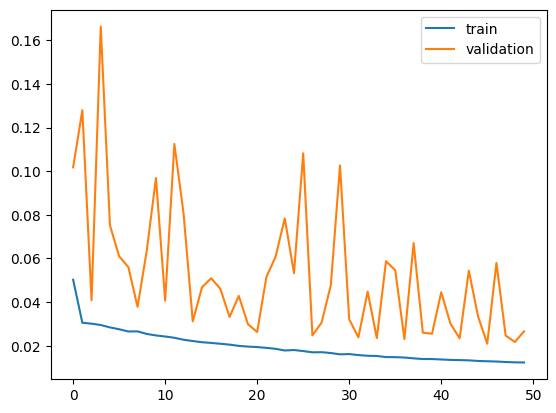

rnn1: 0.026581693440675735
rnn1: 0.037285417318344116


In [123]:
rnn1_rms=train_and_evaluate_RMSprop(rnn1)

RMSprop


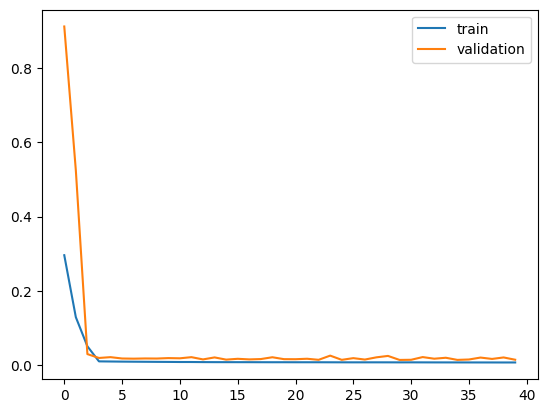

rnn2: 0.014445409178733826
rnn2: 0.02232191525399685


In [125]:
rnn2_rms=train_and_evaluate_RMSprop(rnn2)

RMSprop


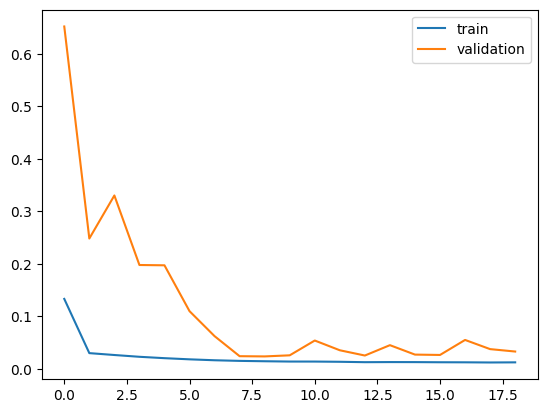

lstm1: 0.03301907330751419
lstm1: 0.196052685379982


In [128]:
lstm1_rms=train_and_evaluate_RMSprop(lstm1)

RMSprop


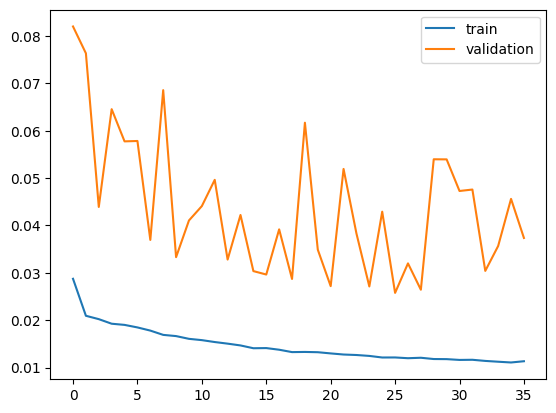

conv1: 0.037358954548835754
conv1: 0.05253862962126732


In [133]:
conv1_rms=train_and_evaluate_RMSprop(conv1)

>Adam Opimizer

adam


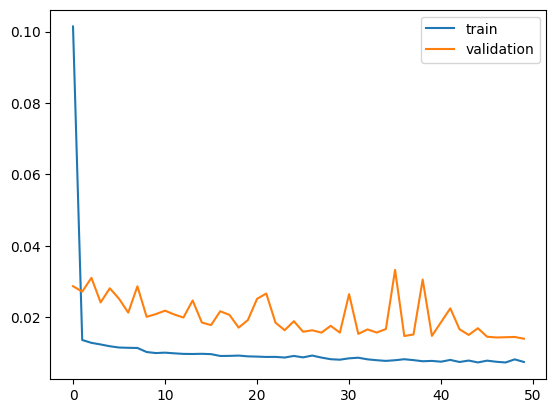

fc1: 0.013945289887487888
fc1: 0.022358933463692665


In [134]:
fc1_adam=train_and_evaluate_Adam(fc1)

adam


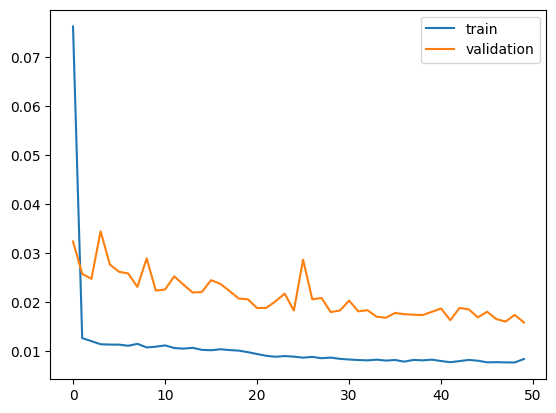

fc2: 0.015815749764442444
fc2: 0.02422882243990898


In [137]:
fc2_adam=train_and_evaluate_Adam(fc2)

adam


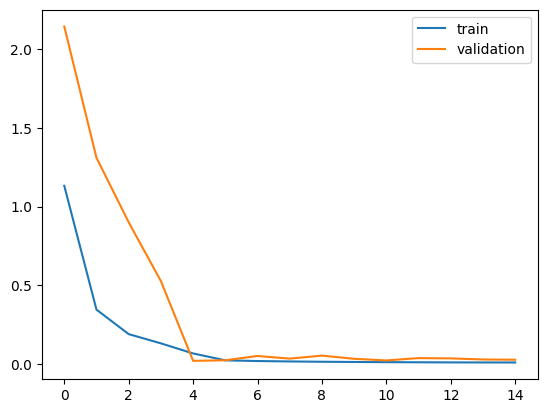

rnn1: 0.026684679090976715
rnn1: 0.12021645158529282


In [138]:
rnn1_adam=train_and_evaluate_Adam(rnn1)

adam


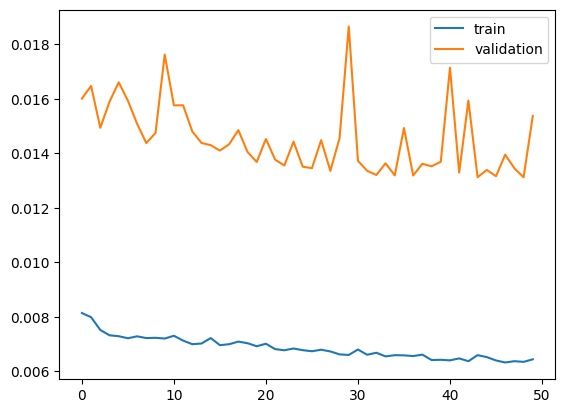

rnn2: 0.015377302654087543
rnn2: 0.02221130020916462


In [139]:
rnn2_adam=train_and_evaluate_Adam(rnn2)

adam


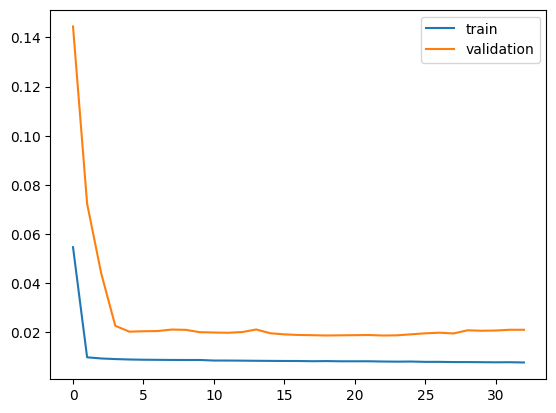

lstm1: 0.021044734865427017
lstm1: 0.05027556046843529


In [229]:
lstm1_adam=train_and_evaluate_Adam(lstm1)

adam


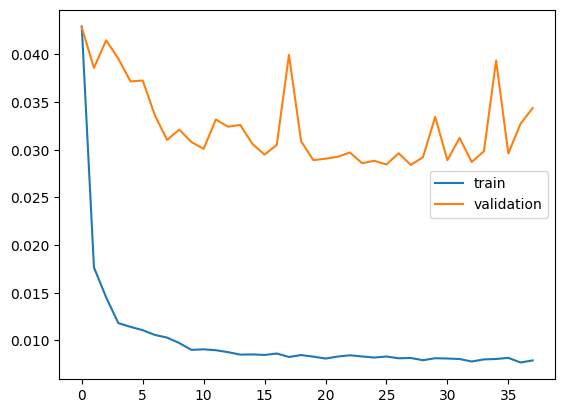

conv1: 0.0343778133392334
conv1: 0.04898470267653465


In [146]:
conv1_adam=train_and_evaluate_Adam(conv1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


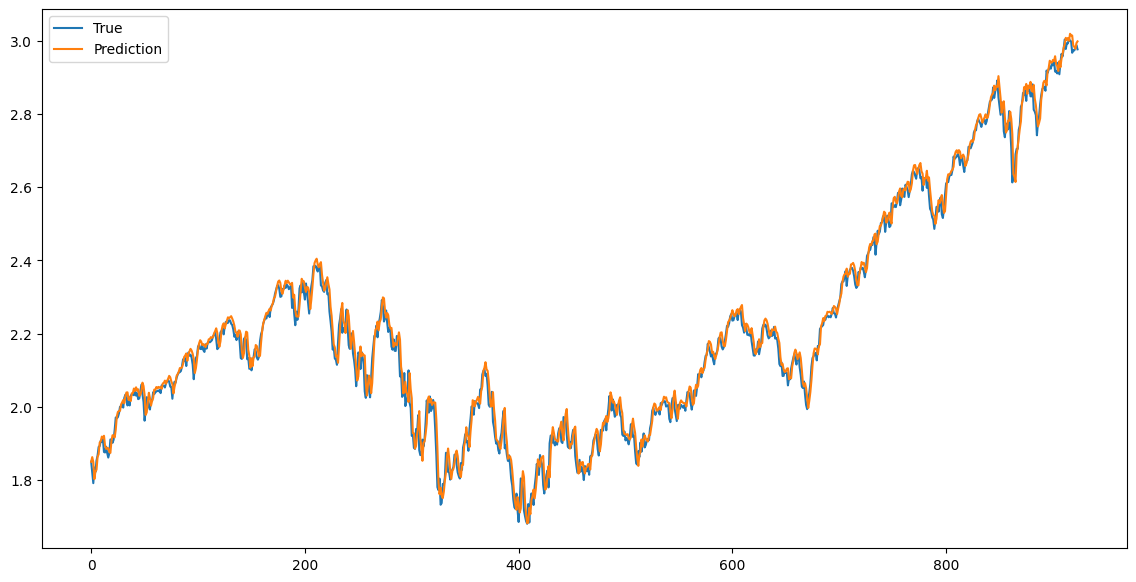

In [231]:
#plot the prediction
def plot_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(14, 7))
    plt.plot(y_test, label='True')
    plt.plot(y_pred, label='Prediction')
    plt.legend()
    plt.show()

plot_predictions(rnn2_rms, X_test, y_test)

In [232]:
#save the model
def save_model(model, filename):
    model.save(filename)

save_model(rnn2_rms, 'rnn2_rms.h5')

In [ ]:
ticker = "^GSPC"
test_new = yf.download(ticker, start="2024-10-17", end="2024-11-30")
test_new.to_csv("test_new.csv", header=["AdjClose","Close","High","Low","Open","Volume"])
test_new = pd.read_csv("test_new.csv", index_col=0)
test_new = test_new[['AdjClose']]
test_new_scaled = (test_new['AdjClose'] - min_train) / (max_train - min_train)
test_new_scaled = test_new_scaled.values
X_test_new, y_test_new = create_dataset(test_new_scaled, look_back)
X_test_new = X_test_new.reshape(X_test_new.shape[0], X_test_new.shape[1], 1)
plot_predictions(rnn2_rms, X_test_new, y_test_new)